In [1]:
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader

from MetropolisHastings import MetropolisHastingsSampler,MoreauYosidaPrior
from FEM_Solver import  RootFinder,FEMSolver
from utilities import *

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from GaLa import llaplace
from NN import DNN

#np.random.seed(1234)

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

/home/s2113174/anaconda3/envs/fenicsx-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Tiaming Experiment 3

$$-\frac{d}{dx}(e^{k(x,\theta)}\frac{du(x)}{dx}) = 4x, \quad x\in (0,1),\theta \in [-1,1]$$
$$u(0) = 0, u(1)=2$$

where $k(x,\theta)$ has the following form:
 
$$  
k(x,\theta) =exp \left( \sum_{n=1}^{2} \sqrt a_{n} \theta_{n} b_{n}(x)  \right)
$$

where $a_{n} = \frac{8}{w_{n}^{2} + 16}$ and $b_{n} = A_{n}\left(  \text{sin}(w_{n}x) + \frac{w_{n}}{4} \text{cos}(w_{n}x) \right)$, $w_{n}$ is the $n_{th}$ solution of the equation $\text{tan} (w_{n}) = \frac{8w_{n}}{w_{n}^{2}-16}$ and $A_{n}$ is a constant of normalization which makes $\|b_{n}\| = 1$.

## Computing Roots

The first 2 roots are: [1.5707963267941523, 2.153747972623023]


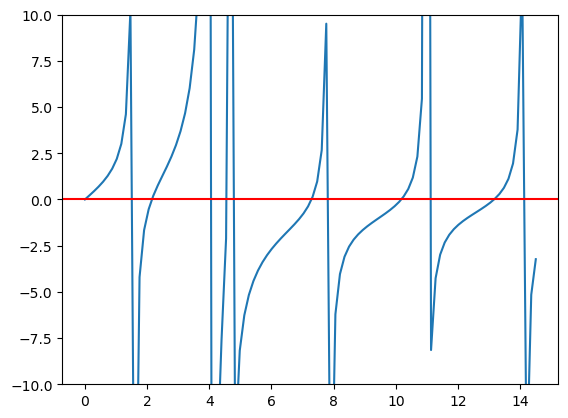

In [2]:
def tang_eq(x):
    return np.tan(x) - 8*(x/(x**2 - 16))

intervals = [(1,2),(2,3),(3.8,4.1),(4.1,4.6),(4.7,4.8),(7.2,7.3),(7.3,8),(10,10.2),(10.2,11.5),(13,13.2),(14,14.5)]
n = 2

root_finder = RootFinder(n, tang_eq, intervals)
roots = root_finder.find_roots()
root_finder.plot_equation()

print(f"The first {n} roots are: {roots}")

theta_t = np.array([0.09762701, 0.43037873, 0.20552675, 0.08976637, -0.1526904, 0.29178823, -0.12482558, 0.783546, 0.92732552, -0.23311696])

In [3]:
def k_function(data_domain,w=roots):
    
    x = data_domain[:,0].reshape(-1,1)
    theta = data_domain[:,1:].reshape(x.shape[0],-1)

    A = torch.sqrt(1 / ( (1/8)*(5 + (w / 2)**2) +  (torch.sin(2*w) / (4*w))*((w / 4)**2 - 1) - (torch.cos(2*w)/8)))
    
    bn =  A*(torch.sin(w*x) + ((w)/(4))*torch.cos(w*x))

    an = torch.sqrt(8 / (w**2 + 16))

    return torch.sum(an*bn*theta,dim=1)

def de(self,data_domain,k = k_function,roots = torch.tensor(roots,dtype=float).reshape(1,-1)):
    """ The pytorch autograd version of calculating residual """
    u = self(data_domain)

    du = torch.autograd.grad(
        u, data_domain, 
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]

    k = k(data_domain,roots)
    
    ddu_x = torch.autograd.grad(
        torch.exp(k).reshape(-1,1)*du[:,0].reshape(-1,1),data_domain, 
        grad_outputs=torch.ones_like(du[:,0].reshape(-1,1)),
        retain_graph=True,
        create_graph=True
        )[0]
        
    return ddu_x[:,0].reshape(-1,1) + 4*data_domain[:,0].reshape(-1,1)


def bc_l(self,data_bc):
    u = self(data_bc)
    return u.reshape(-1,1)

def bc_r(self,data_bc):
    u = self(data_bc)
    return u.reshape(-1,1)- 2

DNN.de = de
DNN.bc_l = bc_l
DNN.bc_r = bc_r

In [4]:
# Number of observations
epochs = 500

N = [150,500,1000,1500]
sample_size = [50,75,125,150]
weights = [5,10,20]

lr = 0.01


In [5]:
# data_parameters = samples_param(3000, nparam=2)
# param_train, param_test = data_parameters[:1500,:],  data_parameters[1500:,:]

# for w in weights:
#     for nobs in N:

#         dataset = dGDataset(size = nobs, param=param_train)

#         x_val,param_val, sol_val = generate_test_data(nobs,param =param_test, vert=30)

#         for ss in sample_size:
#                 layers = [3] + 1*[w] + [1]
                
#                 model = DNN(layers)

#                 dataloader = DataLoader(dataset, batch_size=ss, shuffle=False)

#                 loss = torch.nn.MSELoss(reduction ='mean')

#                 optimizer = torch.optim.Adam(model.parameters(), lr = lr)

#                 loss_adam = train_adam(dataloader,model, loss, optimizer, epochs,param_val,x_val,sol_val, device)


#                 np.save(f'./Models/adam_only_train_w{w}_N{nobs}_batch{ss}.npy', loss_adam[0])
#                 np.save(f'./Models/adam_only_test_w{w}_N{nobs}_batch{ss}.npy', loss_adam[1]) 

#                 path = f"./Models/1dElliptic_adam_PDE2_w{w}_N{nobs}_batch{ss}.pt"
#                 torch.save(model.state_dict(),path)

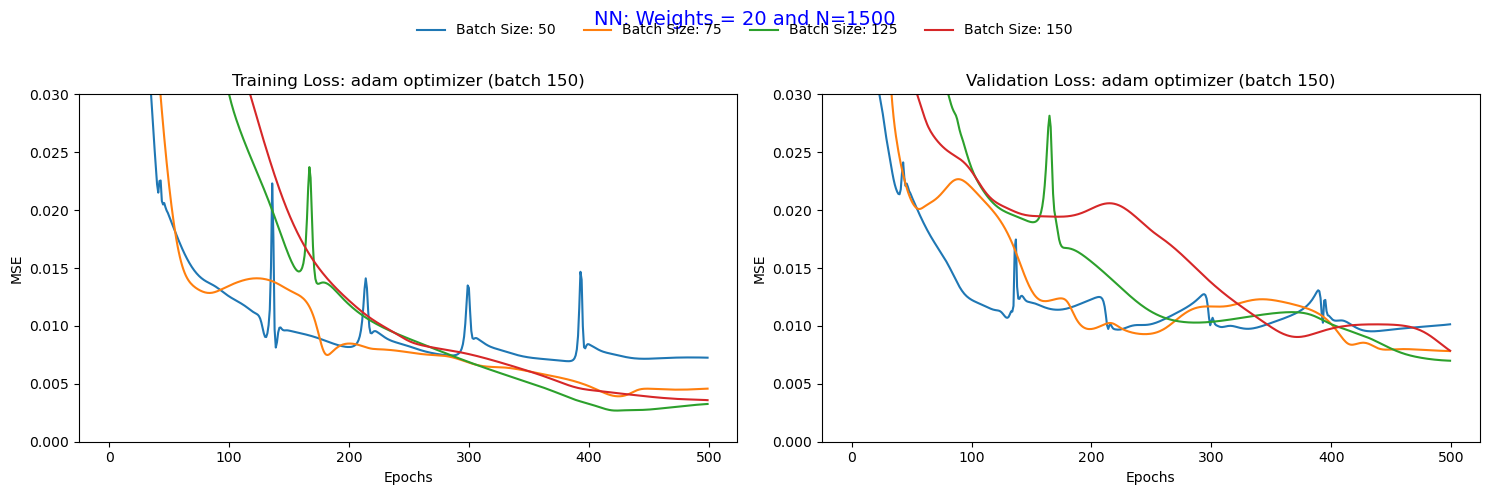

In [6]:
w,nobs =  20,1500

plot_loss_dynamics(w, nobs, sample_size, file_prefix="_only", 
                   include_lbfgs=False,adltrain=0.03, adltest=0.03, lbfgsltrain=0.03, lbfgsltest=0.02)

# Error Analysis

In [7]:
ntest, vert = 1500, 30

x_test,param_test, sol_test = generate_test_data(ntest, vert=vert)

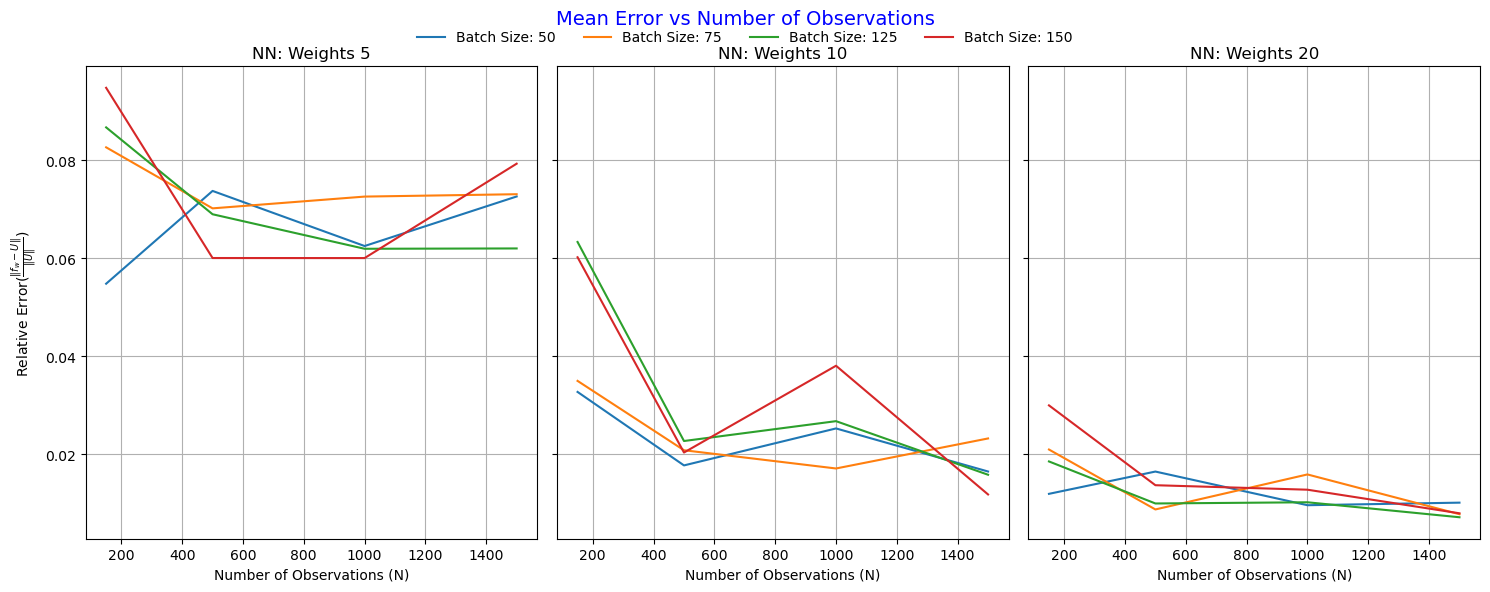

In [8]:
path = "./Models/1dElliptic_adam_PDE2_w{w}_N{nobs}_batch{ss}.pt"

plot_mean_error(weights, sample_size, N, param_test, x_test, sol_test, DNN,path)

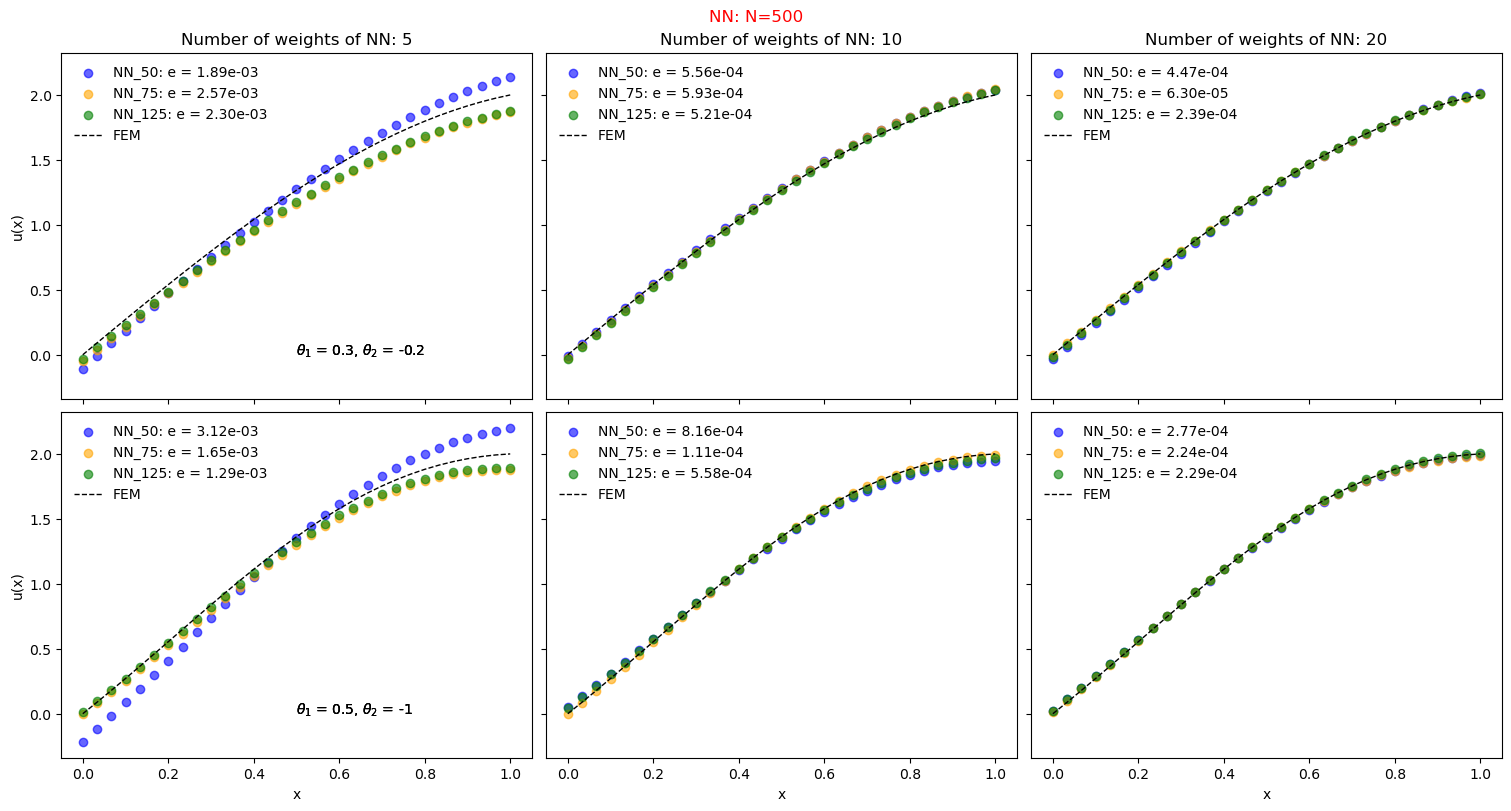

In [9]:
plot_nn_vs_fem(weights, param_test, x_test, sol_test, sample_size,path ,DNN, nobs=500)

In [10]:

# Define intervals for root finding
intervals = [(1, 2), (2, 3), (3.8, 4.1), (4.1, 4.6), (4.7, 4.8), 
                 (7.2, 7.3), (7.3, 8), (10, 10.2), (10.2, 11.5), 
                 (13, 13.2), (14, 14.5)]
    
def tang_eq(x):
    """Equation for root-finding."""
    return np.tan(x) - 8 * (x / (x**2 - 16))

    # Initialize root finder and find roots (assuming RootFinder class is already implemented)
root_finder = RootFinder(2, tang_eq, intervals)

roots = root_finder.find_roots()

NNpr, grid = 5, 75

# results, X, Y = compute_max_error(N, NNpr, roots ,grid=75, 
#                  model_dir='./Models/', model_prefix='1dElliptic_adam_PDE2',batch = 150)

# plot_max_errors(N, results, X, Y, NNpr)

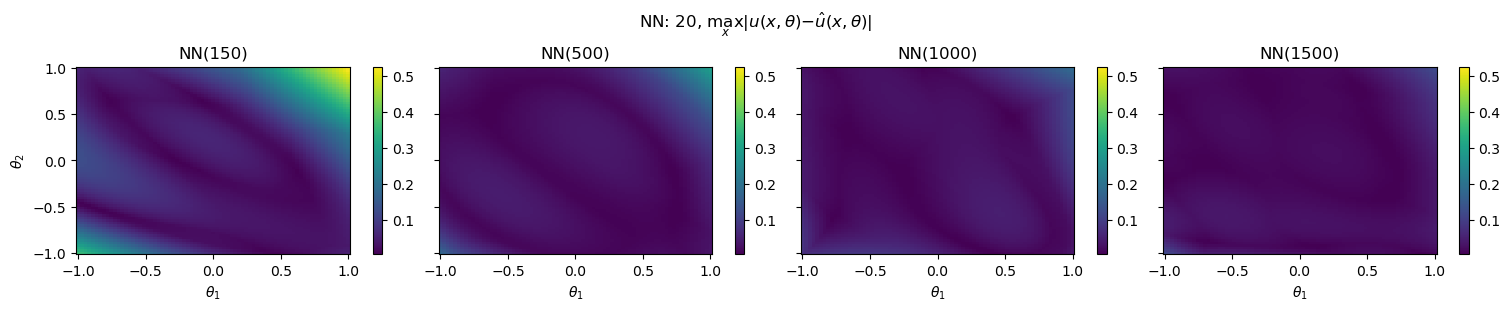

In [11]:
NNpr, grid = 20, 75

results, X, Y = compute_max_error(N, NNpr, roots ,grid=75, 
                 model_dir='./Models/', model_prefix='1dElliptic_adam_PDE2',batch = 150)

plot_max_errors(N, results, X, Y, NNpr)

In [12]:
for i in range(3):
    mean, var = results[:,:,i].mean(),results[:,:,i].var()
    print(f"NN({N[i]}) mean:{mean:.3f} and var: {var:.3f}")

NN(150) mean:0.077 and var: 0.008
NN(500) mean:0.032 and var: 0.001
NN(1000) mean:0.030 and var: 0.001


# Generating Artificial Data for Inverse Problem

# Inverse problem through MCMC

In [13]:
obs = 10
theta_th=np.array([0.098, 0.430])
mean, var = 0,[1e-4,5e-4,1e-3,5e-3]


# for vr in var:
#     st = np.sqrt(vr)
#     obs_points, obs_sol = generate_noisy_obs(obs, theta_t=theta_th, mean=mean, std=st,vert=200)

#     sampler = MetropolisHastingsSampler(obs_points, obs_sol, sig = st,numerical = True, roots=roots, vert=50)

#     samp_num,dt_tracker_num = sampler.run_sampler(n_chains=100000)

#     np.save(f'./Models/FEM_var{vr}_adam_Samples.npy', samp_num)

#     for nobs in N:
#         layers = [3] + 1*[20] + [1]     
#         model = DNN(layers)
#         model.load_state_dict(torch.load(f"./Models/1dElliptic_adam_PDE2_w20_N{nobs}_batch150.pt"))
#         model.eval()        

#         sampler = MetropolisHastingsSampler(obs_points, obs_sol,surrogate=model, sig = st)
#         nsamples, dt_progres = sampler.run_sampler(n_chains=100000)
        
#         np.save(f'./Models/NN_var{vr}_{nobs}_Samples.npy', nsamples)

(100000, 2)


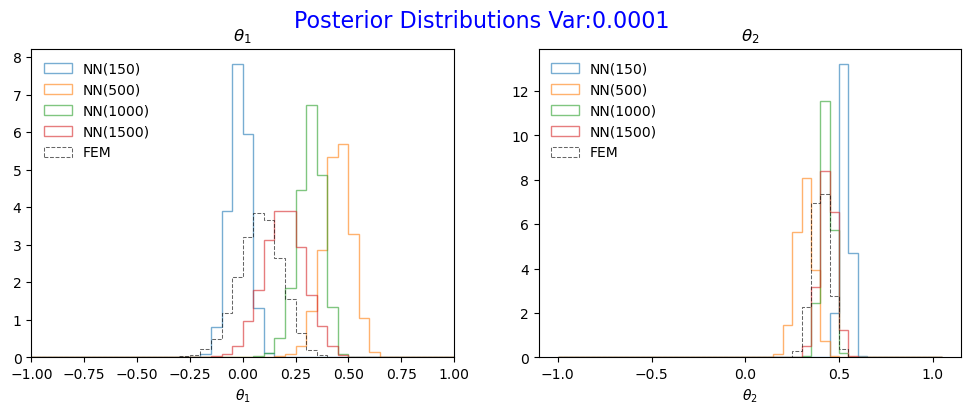

(100000, 2)


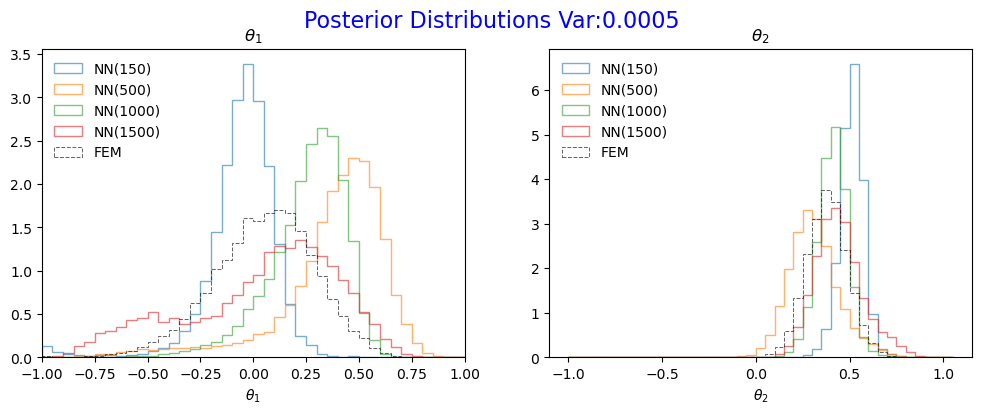

(100000, 2)


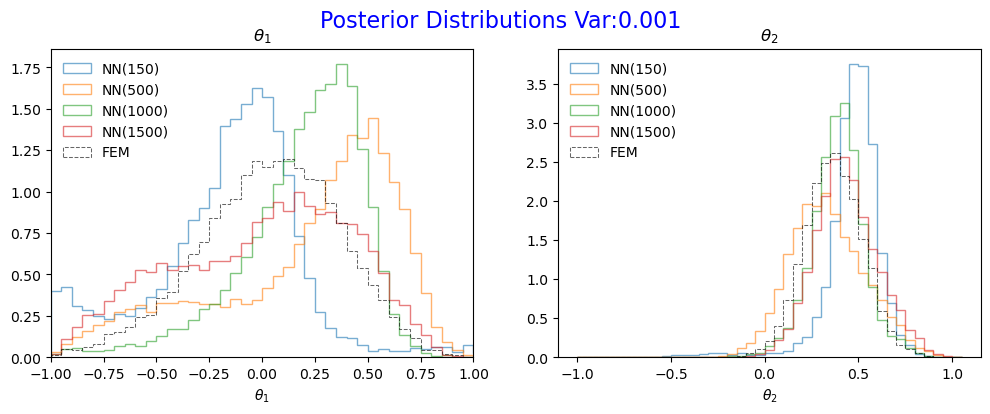

(100000, 2)


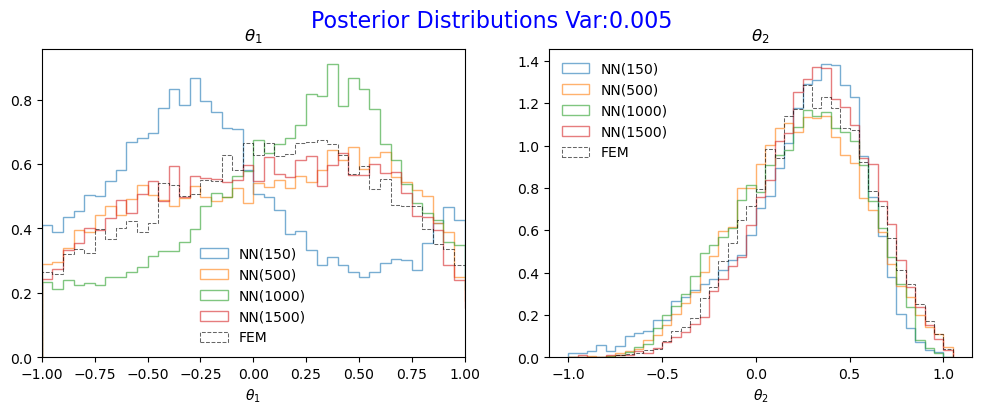

In [14]:
for vr in var:
    samp_num = np.load(f'./Models/FEM_var{vr}_adam_Samples.npy')
    print(samp_num.shape)
    samples = dict()

    for nobs in N:
        samples[nobs] = np.load(f'./Models/NN_var{vr}_{nobs}_Samples.npy')

    plot_posterior_distributions(samples, N, samp_num,sufix="Var:" + str(vr))

# deepGaLA

(100000, 2)


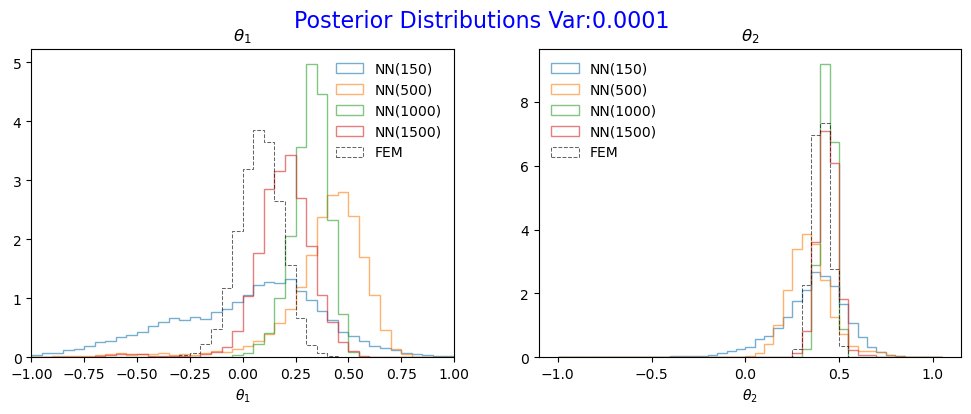

(100000, 2)


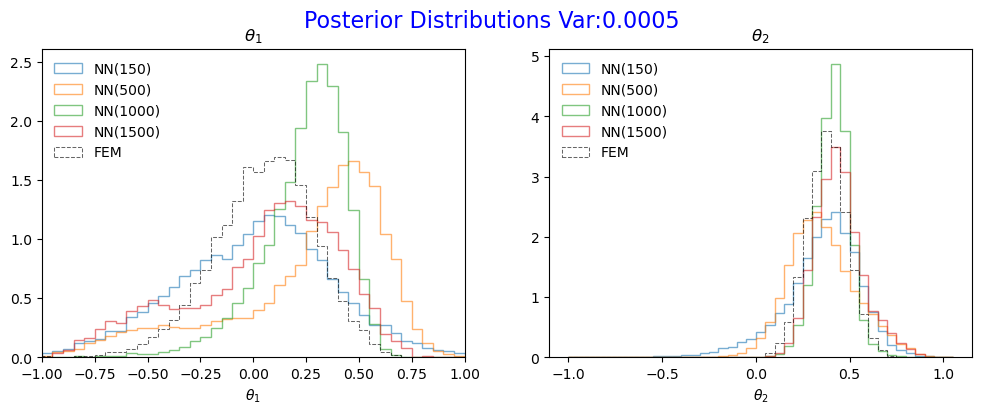

(100000, 2)


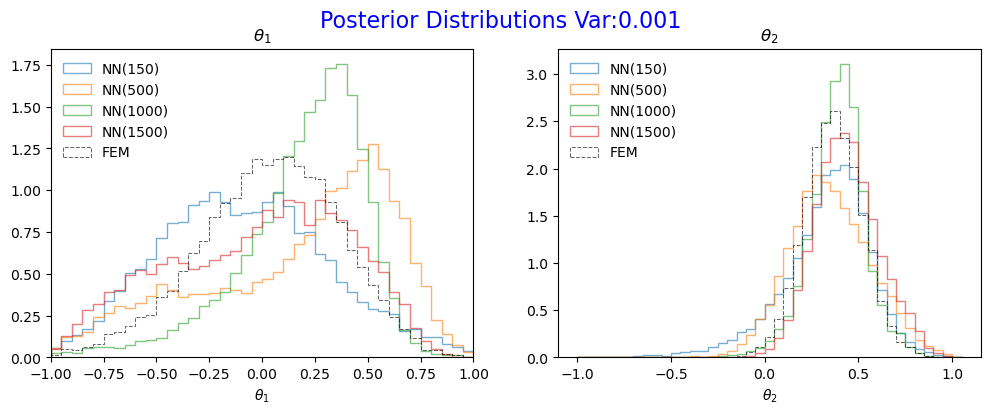

(100000, 2)


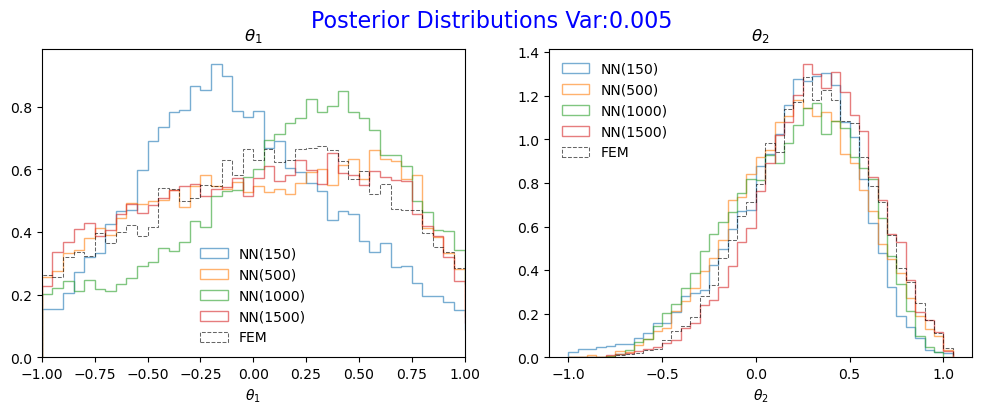

In [15]:
for vr in var:
    samp_num = np.load(f'./Models/FEM_var{vr}_adam_Samples.npy')
    print(samp_num.shape)
    samples = dict()

    for nobs in N:
        samples[nobs] = np.load(f'./Models/dGaLA_var{vr}_{nobs}_Samples.npy')

    plot_posterior_distributions(samples, N, samp_num,sufix="Var:" + str(vr))

# Pyro
## Inverse Problem with Uncertainty in the Surrogate

In [46]:
import pyro
import pyro.distributions as dist
import pyro.infer.mcmc as mcmc
from pyro.infer.mcmc import MCMC
import torch
from FEM_Solver import  FEMSolver

def model_dgala(surrogate,synthetic_data, points, sig,device='cpu'):

    lam = 0.001  # Set your lambda value for the Moreau-Yosida prior
    moreau_prior = MoreauYosidaPrior(lam,device=device)

    # Prior for the parameters theta (assuming 2 parameters)
    theta = pyro.sample("theta", moreau_prior.expand([2]))

    data_test = torch.cat([points, theta.repeat(points.size(0), 1)], dim=1)

    surg_mu, surg_sigma = surrogate(data_test)

    surg_mu = surg_mu.view(-1, 1)

    surg_sigma = surg_sigma[:, :, 0].view(-1, 1)

    sigma = sig ** 2 + surg_sigma

    # Likelihood: Gaussian likelihood with a fixed standard deviation
    y = pyro.sample("obs", dist.Normal(surg_mu, torch.sqrt(sigma)).to_event(1), obs=torch.Tensor(synthetic_data).to(device))

    return y

def model_nn(surrogate,synthetic_data, points, sig,device='cpu'):

    lam = 0.001  # Set your lambda value for the Moreau-Yosida prior
    moreau_prior = MoreauYosidaPrior(lam,device=device)

    # Prior for the parameters theta (assuming 2 parameters)
    theta = pyro.sample("theta", moreau_prior.expand([2]))

    data_test = torch.cat([points, theta.repeat(points.size(0), 1)], dim=1)

    surg_mu = surrogate(data_test)

    surg_mu = surg_mu.view(-1, 1)

    # Likelihood: Gaussian likelihood with a fixed standard deviation
    y = pyro.sample("obs", dist.Normal(surg_mu, sig).to_event(1), obs=torch.Tensor(synthetic_data).to(device))

    return y

In [47]:

obs = 10
theta_th=np.array([0.098, 0.430])
mean, var = 0,[1e-4,5e-4,1e-3,5e-3]
N = [150,500,1000,1500]


#### Samples From Surrogate
layers = [3] + 1*[20] + [1]

for vr in var:
    st = torch.sqrt(torch.tensor(vr))
    obs_points, obs_sol = generate_noisy_obs(obs, theta_t=theta_th, mean=mean, std=st,vert=200)
    obs_points, obs_sol = torch.tensor(obs_points, dtype=torch.float32),torch.tensor(obs_sol, dtype=torch.float32)


    for nobs in N:
        model = DNN(layers).to(device)
        model.load_state_dict(torch.load(f"./Models/1dElliptic_adam_PDE2_w20_N{nobs}_batch150.pt"))
        model.eval()

        kernel = mcmc.RandomWalkKernel(model_nn, target_accept_prob=0.234)

        mcmc_sampler = MCMC(kernel, num_samples=1000000, warmup_steps=5000)

        mcmc_sampler.run(model,obs_sol,obs_points,st)

        # Get the results (posterior samples)
        samples = mcmc_sampler.get_samples()
        samples = samples["theta"].numpy()

        np.save(f'./Models/NN_var{vr}_{nobs}_Samples_pyro.npy', samples)
        del kernel, mcmc_sampler, samples

        # ##### Deep GaLA
        # data_int,left_bc,right_bc = generate_data(nobs)
        # data_int,left_bc,right_bc  = data_int.to(device),left_bc.to(device),right_bc.to(device)

        # pde = {"PDE":["de","bc_l","bc_r"], 
        #     "data_set":{"de" : Variable(data_int,requires_grad=True),
        #     "bc_l":left_bc,
        #     "bc_r" :right_bc}}
        
        # llp = llaplace(model)
        # llp.fit(pde=pde, hessian_structure = "full")

        # log_prior, log_sigma = torch.ones(1, requires_grad=True), torch.ones(1, requires_grad=True)
        # hyper_optimizer = torch.optim.Adam([log_prior.to(device), log_sigma.to(device)], lr=1e-2)

        # error = 1.0  # Initialize error to start the loop
        # n_iter = 0

        # while error > 1e-3 or n_iter == 3000:
        #     # Clone the values at the start of the iteration to use later for error calculation
        #     prev_log_prior, prev_log_sigma = log_prior.clone(), log_sigma.clone()

        #     hyper_optimizer.zero_grad()

        #     # Calculate negative marginal likelihood
        #     neg_marglik = -llp.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
        #     neg_marglik.backward(retain_graph=True)

        #     # Perform optimization step
        #     hyper_optimizer.step()

        #     # Calculate error directly in PyTorch
        #     error = 0.5 * (torch.abs(log_prior - prev_log_prior) + torch.abs(log_sigma - prev_log_sigma)).item()
        #     n_iter +=1

        # kernel = mcmc.RandomWalkKernel(model_dgala, target_accept_prob=0.234)

        # mcmc_sampler = MCMC(kernel, num_samples=1000000, warmup_steps=5000)

        # mcmc_sampler.run(llp,obs_sol,obs_points,st)

        # # Get the results (posterior samples)
        # samples = mcmc_sampler.get_samples()
        # samples = samples["theta"].numpy()

        # np.save(f'./Models/dGaLA_var{vr}_{nobs}_Samples_pyro.npy', samples)

        # del kernel, mcmc_sampler, samples


Sample: 100%|██████████| 1005000/1005000 [06:01, 2781.54it/s, step size=7.44e-01, acc. prob=0.238]


(100000, 2)


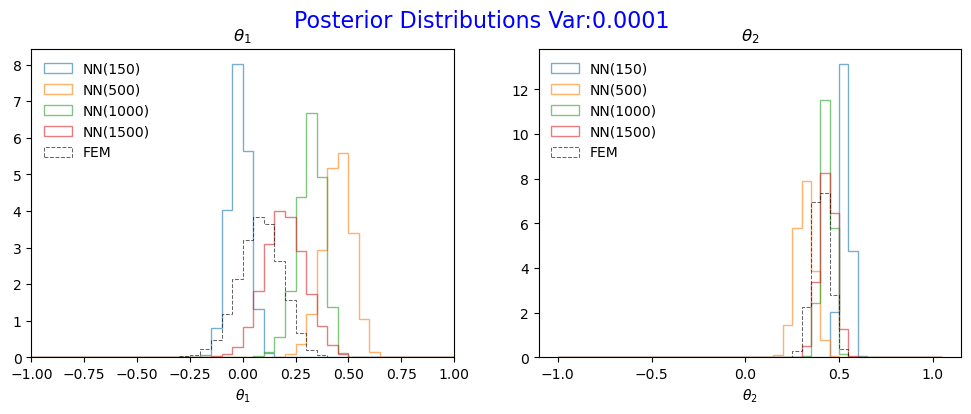

(100000, 2)


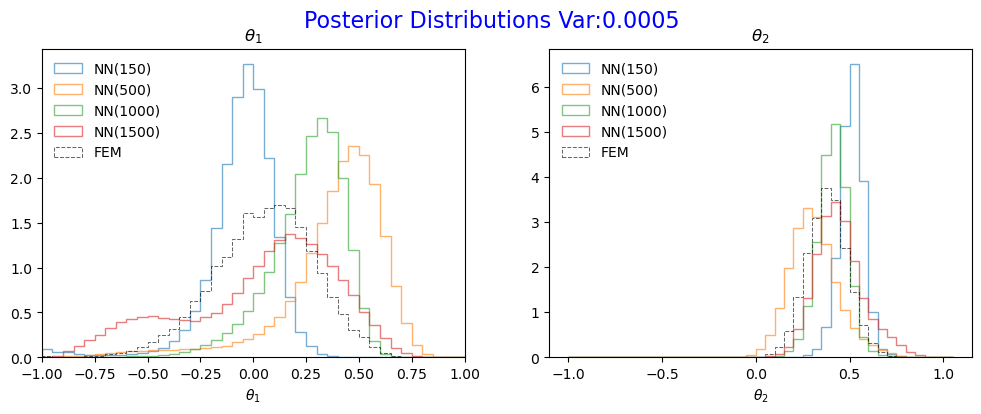

(100000, 2)


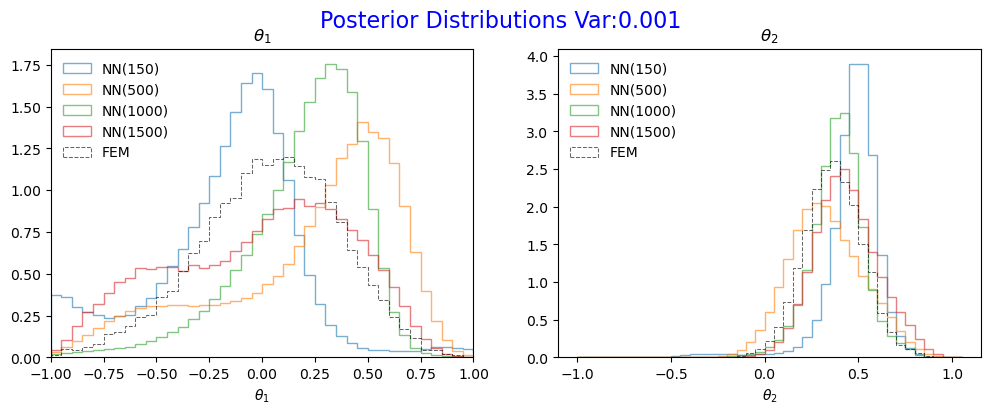

(100000, 2)


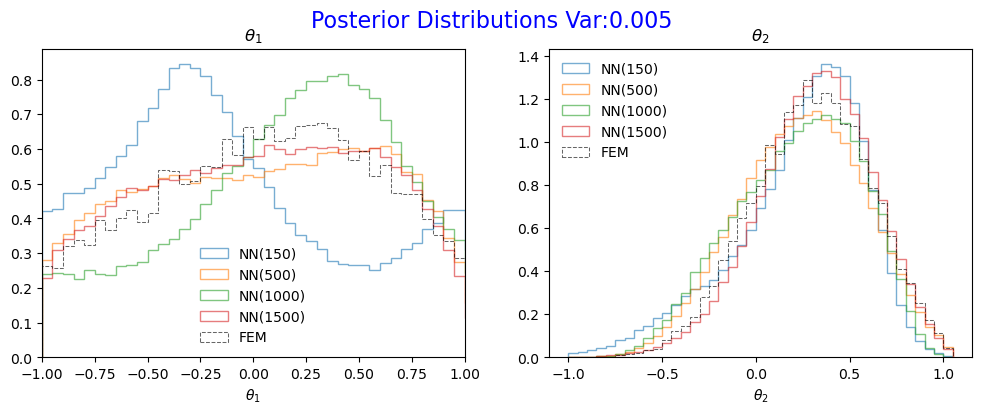

In [48]:
for vr in var:
    samp_num = np.load(f'./Models/FEM_var{vr}_adam_Samples.npy')
    print(samp_num.shape)
    samples = dict()

    for nobs in N:
        samples[nobs] = np.load(f'./Models/NN_var{vr}_{nobs}_Samples_pyro.npy')

    plot_posterior_distributions(samples, N, samp_num,sufix="Var:" + str(vr))

(100000, 2)


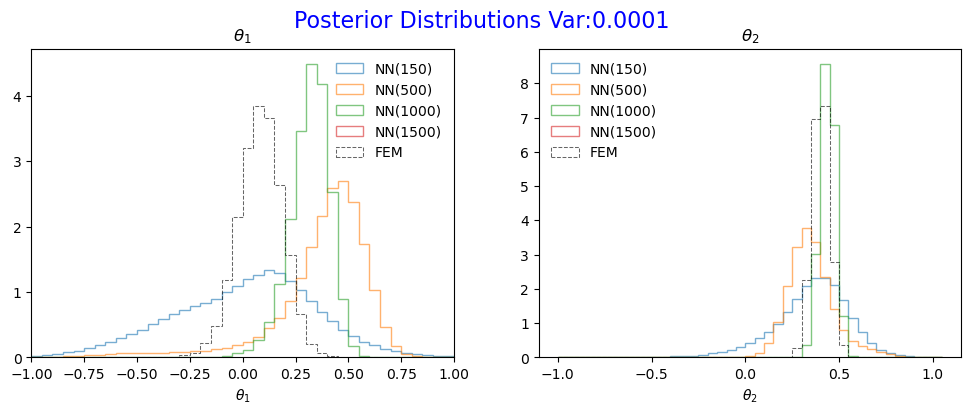

(100000, 2)


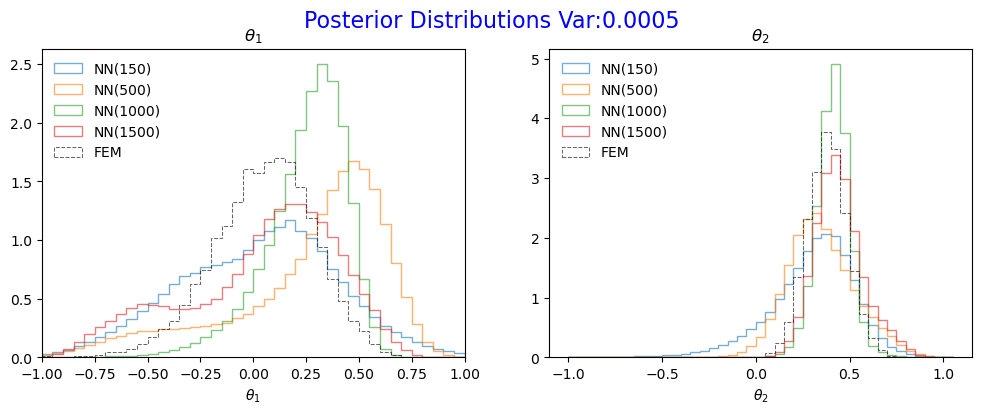

(100000, 2)


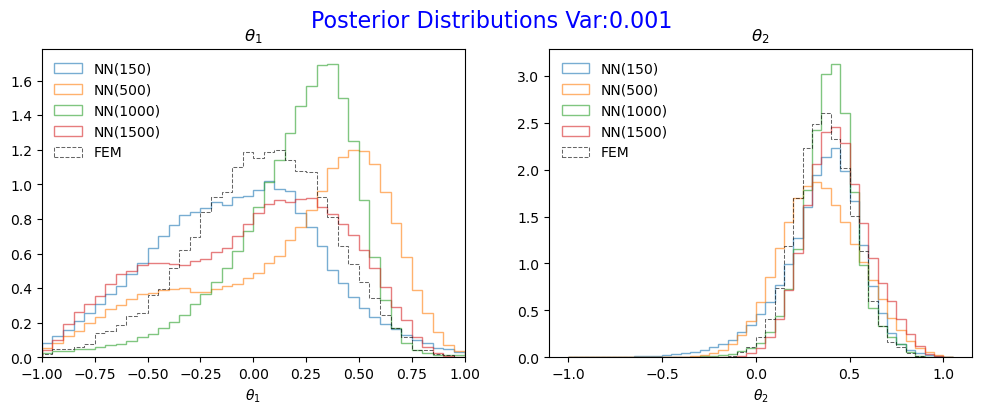

(100000, 2)


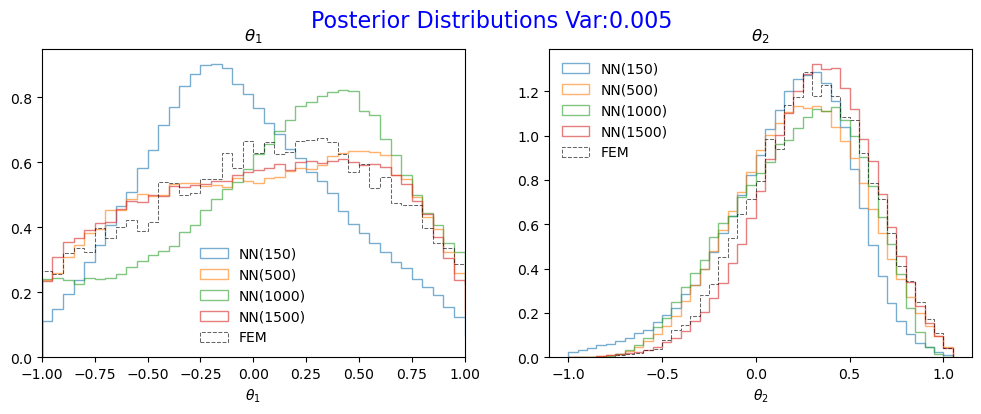

In [45]:
for vr in var:
    samp_num = np.load(f'./Models/FEM_var{vr}_adam_Samples.npy')
    print(samp_num.shape)
    samples = dict()

    for nobs in N:
        samples[nobs] = np.load(f'./Models/dGaLA_var{vr}_{nobs}_Samples_pyro.npy')

    plot_posterior_distributions(samples, N, samp_num,sufix="Var:" + str(vr))

In [32]:
# deepGala = dict()

# layers = [3] + 1*[20] + [1]

# for nobs in N:
#        data_int,left_bc,right_bc = generate_data(nobs)

#        model = DNN(layers)
#        path = f"./Models/1dElliptic_adam_PDE2_w20_N{nobs}_batch150.pt"
#        model.load_state_dict(torch.load(path))
#        model.eval()

#        pde = {"PDE":["de","bc_l","bc_r"], 
#               "data_set":{"de" : Variable(data_int,requires_grad=True),
#                      "bc_l":left_bc,
#                      "bc_r" :right_bc}}

#        llp = llaplace(model)
#        llp.fit(pde=pde, hessian_structure = "full")

#        log_prior, log_sigma = torch.ones(1, requires_grad=True), torch.ones(1, requires_grad=True)
#        hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)
       
#        for i in range(5000):
#               hyper_optimizer.zero_grad()
#               neg_marglik = - llp.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
#               neg_marglik.backward(retain_graph=True)
#               hyper_optimizer.step()
#        deepGala[str(nobs)] = llp

In [33]:
# # Plotting
# fig = plt.figure(figsize=(25,25))
# plt.subplots_adjust(hspace=0.25)
# colors = ["blue","orange","green"]

# for n,(pr1) in enumerate(param_test[:4]):

#     data_test = torch.tensor(np.hstack((x_test, np.ones((x_test.shape[0],pr1.shape[0]))*(pr1)))).float()
#     numerical_sol = sol_test[n,:]

#     plt.subplot(8, 2, n + 1)
#     llp = deepGala[str(N[-1])]

#     u_mean, u_sigma = llp(data_test)
#     u_mean, u_sigma = u_mean.detach().cpu().numpy(), u_sigma[:,:,0].sqrt().detach().cpu().numpy()
#     numerical_sol = numerical_sol.reshape(u_mean.shape)

#     plt.scatter(x_test, u_mean, label = fr"NN_training_{1500}",alpha=0.6 )
#     plt.fill_between(x_test.reshape(-1), (u_mean+2*u_sigma).reshape(-1),(u_mean-2*u_sigma).reshape(-1),alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")

#     plt.plot(x_test, numerical_sol, label = "Numerical Solution")

#     plt.title(fr"Parameters: $\theta_{1}$ = {pr1[0]:.1g} and  $\theta_{2}$ = {pr1[1]:.1g}")
#     plt.xlabel("x")
#     plt.ylabel("u")
#     plt.legend(frameon=False)

In [34]:
#samples_dg,tracker_dg = dict(),dict()

# for nob in N:
#     dgl = deepGala[str(nob)]

#     sampler = MetropolisHastingsSampler(obs_points, obs_sol,surrogate=dgl ,sig = std,mean = False)
#     alpha_samples, dt_progression = sampler.run_sampler(n_chains=100000)
#     samples_dg[nob], tracker_dg[nob] = alpha_samples,dt_progression
#     np.save(f'./Models/dgl_{nob}_adam_Samples.npy', samples_dg[nob])
#     np.save(f'./Models/dgl_{nob}_adam_Step.npy', tracker_dg[nob])

# for nob in N:
#     samples_dg[nob]= np.load(f'./Models/dgl_{nob}_adam_Samples.npy')
#     tracker_dg[nob] = np.load(f'./Models/dgl_{nob}_adam_Step.npy')

In [ ]:
#plot_posterior_distributions(samples, N, samp_num)

In [ ]:
#plot_posterior_distributions(samples_dg, N, samp_num)